In [302]:
# utils
import sys
import time
import scipy
import logging
import numpy as np
import pandas as pd
from collections import Counter

# scRBA
import anndata
import scanpy as sc
from sklearn.metrics.cluster import normalized_mutual_info_score

from pipeline import dl, pp, cl, pl, utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [365]:
autoreload 

In [359]:
dataset_path = pd.read_csv('dataset.txt', header = None, index_col=None)
dataset_path[0][2]

'/projects/zhanglab/data/sc_data/TS_Science_2022/obj_smartseq2_raw.h5ad'

## Preprocess Data

load:  /projects/zhanglab/data/sc_data/TS_Science_2022/obj_smartseq2_raw.h5ad
n_obs × n_vars:  (26813, 34963)
running time:  7.081031799316406e-05
n_obs × n_vars:  (26813, 18259)


/home/chunchua/miniconda3/envs/lab/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


n_obs × n_vars:  (26813, 2000)


/home/chunchua/miniconda3/envs/lab/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/chunchua/miniconda3/envs/lab/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/chunchua/miniconda3/envs/lab/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/chunchua/miniconda3/envs/lab/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: Fu

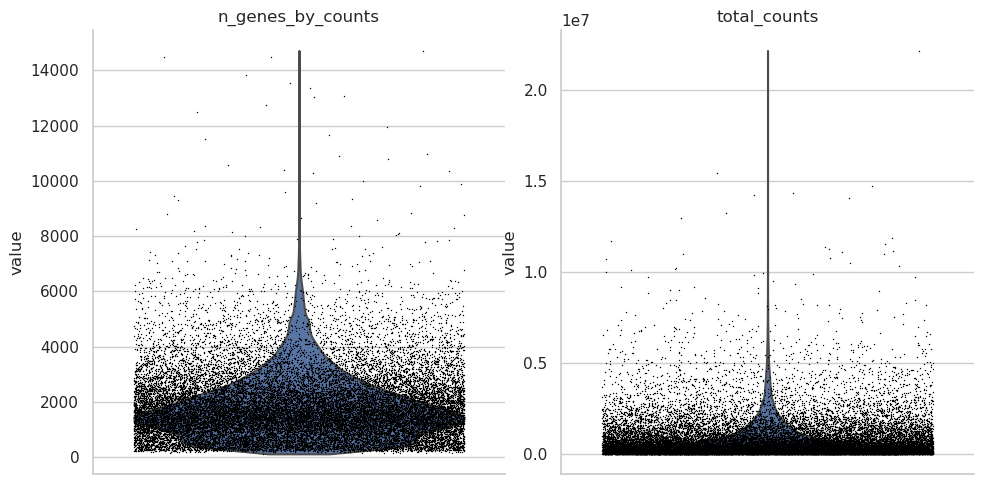

AnnData object with n_obs × n_vars = 26813 × 2000
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'tissue', 'tissue_celltype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt'
    uns: '_scvi', '_training_mode', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 

In [366]:
DATA_PATH = dataset_path[0][2]
adata = dl.load_data(DATA_PATH)
adata = pp.preprocess(adata, min_genes = 100, min_cells = 300, target_sum = 1e4)
adata = pp.hvg(adata)
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts"],
    jitter=0.4,
    multi_panel=True,
)
adata

In [369]:
len(cell_types)

224

In [368]:
cell_types = Counter(adata.obs[target])
cell_types

Counter({'mesenchymal stem cell': 1421,
         'macrophage': 1356,
         'memory b cell': 1040,
         'monocyte': 868,
         'CD4 t cell': 828,
         'basal_cells_confirmed': 785,
         'plasma cell': 781,
         'fibroblast': 750,
         'endothelial cell of vascular tree': 734,
         'mature enterocyte': 678,
         'capillary endothelial cell': 672,
         'classical monocyte': 638,
         'skeletal muscle satellite stem cell': 604,
         'cd8-positive, alpha-beta t cell': 599,
         'innate lymphoid cell': 514,
         'pancreatic acinar cell': 510,
         'B cell': 499,
         'Immune_notvalidated': 493,
         'cd8-positive, alpha-beta memory t cell': 452,
         'cd4-positive, alpha-beta memory t cell': 392,
         'pericyte cell': 375,
         'CD8 t cell': 373,
         'endothelial cell': 358,
         'LTF+ Epithelial Cell': 350,
         'naive thymus-derived cd4-positive, alpha-beta t cell': 343,
         'neutrophil': 320,
 

## Stats

remove nan cell type

In [367]:
adata = adata[adata.obs['free_annotation'] != 'nan']
adata

View of AnnData object with n_obs × n_vars = 26813 × 2000
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'tissue', 'tissue_celltype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt'
    uns: '_scvi', '_training_mode', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_c

In [370]:
target = 'free_annotation'
cell_types = Counter(adata.obs[target])
cell_types = {key: value for key, value in cell_types.items() if value > 200}
print('Number of Cell Types: ', len(cell_types))

Number of Cell Types:  35


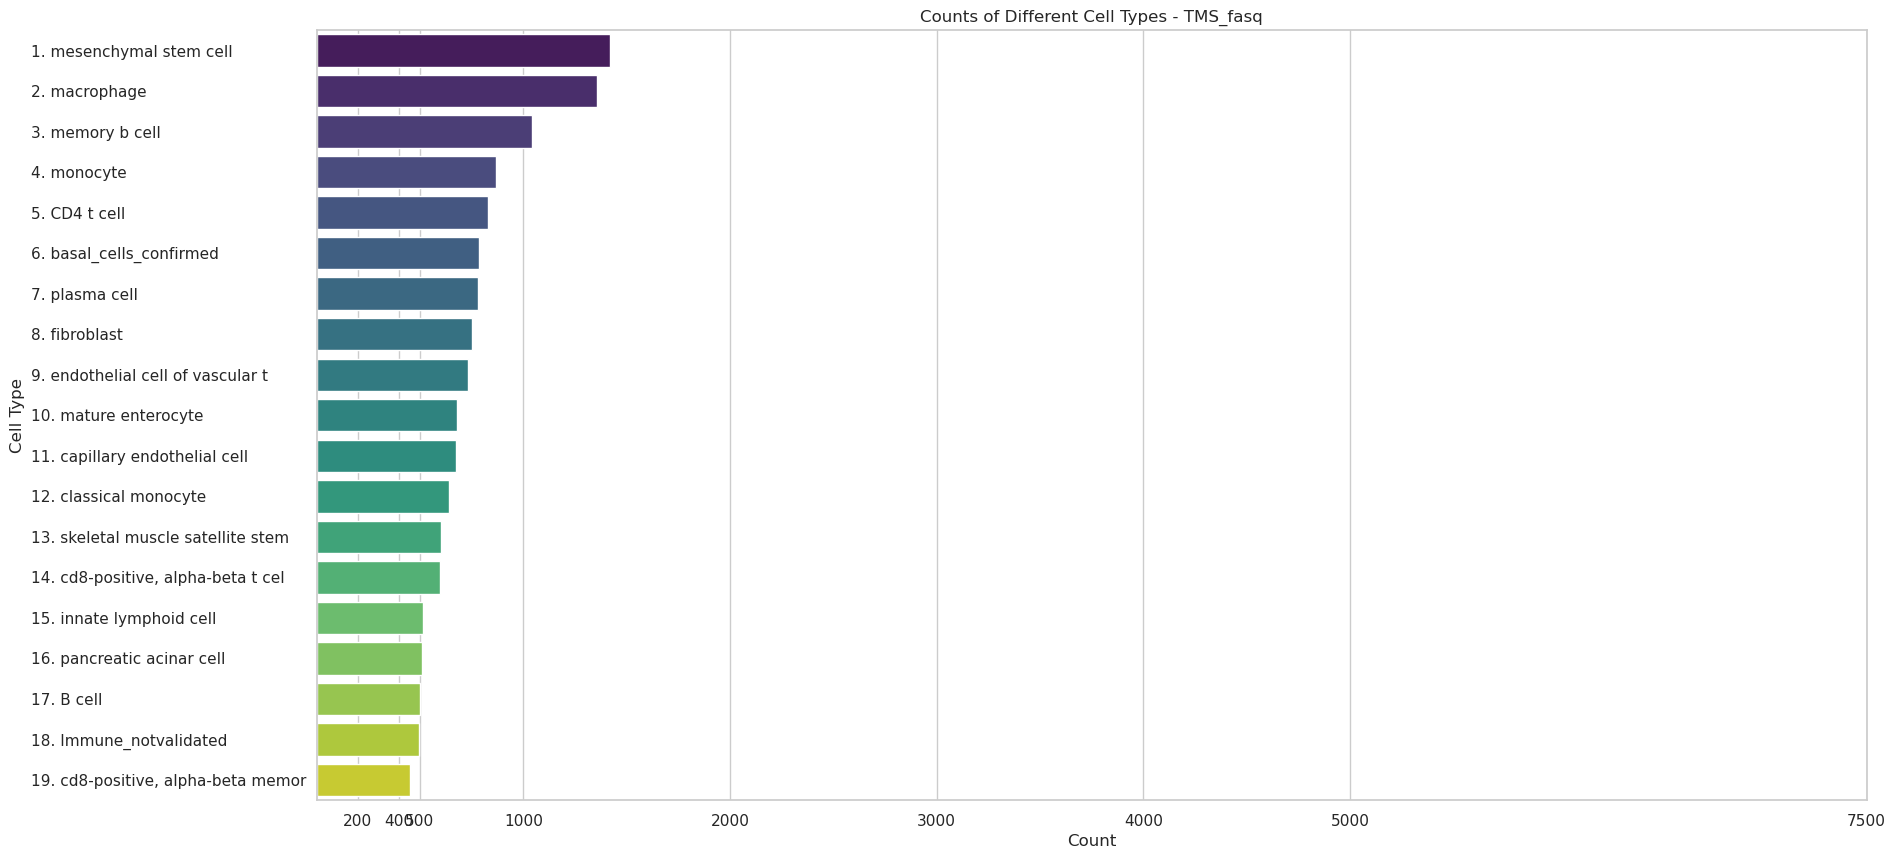

In [364]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.DataFrame(list(cell_types.items()), columns=['Cell Type', 'Count'])

# Sort by count for better visualization
df = df.sort_values(by='Count', ascending=False)

# Set the figure size and style
plt.figure(figsize=(20, 10))
sns.set(style="whitegrid")

# Create a bar plot
ax = sns.barplot(x='Count', y='Cell Type', data=df, palette='viridis')

# Set labels and title
ax.set_xlabel('Count')
ax.set_ylabel('Cell Type')
ax.set_title('Counts of Different Cell Types - TMS_fasq')

# Create new y-tick labels with ranking
y_labels = [f'{i+1}. {cell_type[:30]}' for i, cell_type in enumerate(df['Cell Type'])]
ax.set_yticklabels(y_labels, horizontalalignment='left')
ax.tick_params(axis='y', which='major', pad=200)
ax.set_xticks([200, 400, 500, 1000, 2000, 3000, 4000, 5000, 7500])
plt.show()

## Sampling Framework

In [358]:


def write_sample_data(anndata, dataset, trial, strategy, params):
    """
    Sample data based on different strategies.
    
    Parameters:
    - anndata: The AnnData object to be sampled.
    - strategy: Strategy to be used (1: fixed_cells_per_type, 2: fixed_cell_type_varying_cells, 3: imbalance_ratio).
    - params: Parameters specific to the strategy.
    - dataset: Name of the dataset.
    - trial: Trial number, used for seeding and file naming.
    """
    np.random.seed(42 + trial)  # For reproducibility
    data = adata.copy()
    cell_type_counts = Counter(data.obs[params['label']])

    if strategy == 1:
        cell_type_counts = {key: value for key, value in cell_type_counts.items() if value > 400}
    else:
        cell_type_counts = {key: value for key, value in cell_type_counts.items() if value > 600}
    cell_types = list(cell_type_counts.keys())

    # Fixed number of cell, varying number of cell types
    if strategy == 1:
        
        for n_cell_type in params['cell_types']:

            # list to save sample indices
            sampled_indices = []

            # sample cell types
            sampled_cell_types = np.random.choice(cell_types, n_cell_type, replace = False)

            # select cells for each types
            for cell_type in sampled_cell_types:
                indices = data.obs.index[data.obs[params['label']] == cell_type].tolist()

                # fixed number of cells
                indices = np.random.choice(indices, size = params['cells_per_type'], replace=False)

                # add cell indices to final sample list
                sampled_indices.extend(indices)
            
            path = f'/projects/zhanglab/users/david/data/{dataset}/ct{n_celltype}_t{trial}.h5ad'
            result = data[sampled_indices]

            # print('n_ct: ', n_cell_type, ' - ', write_path)
            # print(result.X.shape, Counter(result.obs[params['label']]))
            result.write(path)
            

    # Fixed cell types, varying number of cells per cell type
    elif strategy == 2:
        
        for n_cell in params['n_cells']:

            # list to save sample indices
            sampled_indices = []

            # sample cell types
            # print('!!!!',n_cell, params['n_cell_type'])
            # print(len(cell_types))
            sampled_cell_types = np.random.choice(cell_types, params['n_cell_type'], replace = False)

            # select cells for each types
            for cell_type in sampled_cell_types:
                indices = data.obs.index[data.obs[params['label']] == cell_type].tolist()

                # fixed number of cells
                indices = np.random.choice(indices, size = n_cell, replace=False)

                # add cell indices to final sample list
                sampled_indices.extend(indices)
            
            path = f'/projects/zhanglab/users/david/data/{dataset}/c{n_cell}_t{trial}.h5ad'
            result = data[sampled_indices]
            
            # print('n_c: ', n_cell, ' - ', write_path)
            # print(result.X.shape, Counter(result.obs[params['label']]))
            result.write(path)

    elif strategy == 3:
        for ratio in params['ratios']:

            sorted_cell_types = sorted(cell_types, key=lambda x: cell_type_counts[x], reverse=True)
            
            major_cell_types = np.random.choice(sorted_cell_types[:len(sorted_cell_types)//2], params['n_major'], replace = False)
            minor_cell_types = np.random.choice(sorted_cell_types[len(sorted_cell_types)//2:], params['n_minor'], replace = False)
            
            sampled_indices = []
            
            # Sampling major cell types
            for cell_type in major_cell_types:
                indices = data.obs.index[data.obs[params['label']] == cell_type].tolist()
                indices = np.random.choice(indices, size = ratio * params['n_cells_base'], replace=False)
                sampled_indices.extend(indices)
    
            # Sampling minor cell types
            for cell_type in minor_cell_types:
                indices = data.obs.index[data.obs[params['label']] == cell_type].tolist()
                indices = np.random.choice(indices, size = params['n_cells_base'], replace=False)
                sampled_indices.extend(indices)
    
            path = f'/projects/zhanglab/users/david/data/{dataset}/imbalance_r{ratio}_t{trial}.h5ad'
            result = data[sampled_indices]
            # print('ratio: ', ratio, '-', path)
            # print(result.X.shape, Counter(result.obs[params['label']]))
            result.write(path)

dataset = 'TMS_drop'
for trial in range(3):
    
    write_sample_data(anndata, dataset, trial, strategy = 1, params = {'label': 'free_annotation','cells_per_type': 400, 'cell_types': [5, 10, 20, 40]})
    write_sample_data(anndata, dataset, trial, strategy = 2, params = {'label': 'free_annotation','n_cells': [50, 100, 200, 400, 600],'n_cell_type': 20})
    write_sample_data(anndata, dataset, trial, strategy = 3, params = {'label': 'free_annotation', 'n_major': 10, 'n_minor': 10, 'ratios': [2, 4, 8], 'n_cells_base': 100, 'n_cell_type': 20})


{'filiform': 1182, 'suprabasal': 2484, 'suprabasal differentiating': 4607, 'parabasal': 1727, 'suprabasal interpapillary': 2864, 'basal cell': 6788, 'proliferating': 2342, 'fibroblast': 2372, 'leukocyte': 1064, 'endocardial endothelial cells': 534, 'coronary vascular endothelial cell': 2946, 'Cd4 positive Macrophages': 988, 'luminal progenitor cell': 852, 'B cell': 3453, 'stromal cell': 2622, 'luminal epithelial cell of mammary gland': 1018, 'endothelial cell': 1033, 'T cell': 2984, 'macrophage': 661, 'Cd36+': 975, 'Cd34+': 1491, 'monocyte': 1034, 'Epcam    kidney proximal convoluted tubule epithelial cell': 4434, 'CD45    macrophage': 1319, 'CD45    B cell': 2495, 'Epcam    thick ascending tube S epithelial cell': 1566, 'Epcam    kidney collecting duct principal cell': 747, 'CD45': 1289, 'Epcam     kidney distal convoluted tubule epithelial cell': 657, 'Pecam    fenestrated capillary endothelial': 855, 'Epcam    podocyte': 486, 'CD45    T cell': 1139, 'Pecam    Kidney cortex artery ce